# Imports

In [1]:
#General imports
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

#Preprocessing
from preprocessing import load_data, creer_feature_ligne

#Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [121]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Preprocessing

In [2]:
data = load_data()

# Clustering + PCA

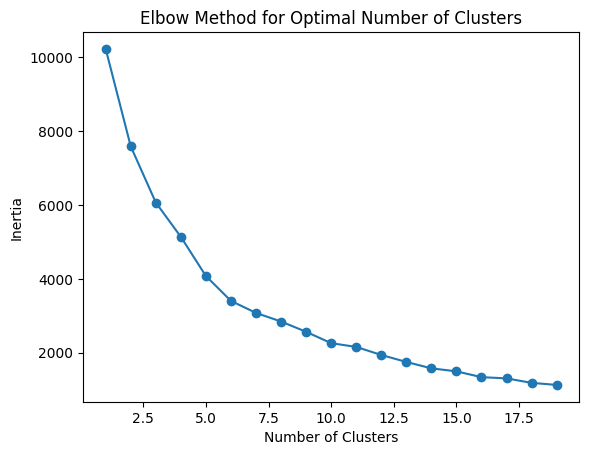

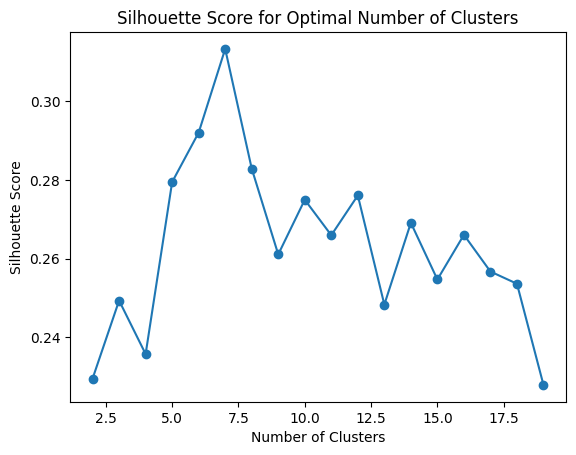

In [3]:
# PREPROCESSING
creer_feature_ligne(data) # ajout des lignes
data['retard_parcours'] = (data['retard_moyen_arrivee']-data['retard_moyen_depart'])/data['duree_moyenne'] # ajout retard relatif au temps de trajet

# extraction de la donnée de 2018
data_clustering = data[data['date'].apply(lambda x: x.split('-')[0]) == '2018']

# agrégation des pourcentages de cause par ligne sur l'année entière (moyenne)
data_clustering = data_clustering.groupby('gare_depart').agg({'prct_cause_externe': 'mean',
                                         'prct_cause_infra': 'mean',
                                         'prct_cause_gestion_trafic': 'mean',
                                         'prct_cause_materiel_roulant': 'mean',
                                         'prct_cause_gestion_gare': 'mean',
                                         'prct_cause_prise_en_charge_voyageurs': 'mean'}).reset_index()


# RECHERCHE DU CLUSTERING OPTIMAL PAR KMEANS
# Par calcul d'inertie (méthode du coude)
inertia = []
cluster_range = range(1, 20)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
    inertia.append(kmeans.inertia_)

plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


# Par utilisation du Silhouette Score
silhouette_scores = []
cluster_range = range(2, 20) 
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
    silhouette_avg = silhouette_score(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score graph
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

The elbow rule recommends fitting the KMeans algo on n_clusters = 6 or 7. The Silhouette Score highly recommends n_clusters = 7. -> This will be our ultimate choice.

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


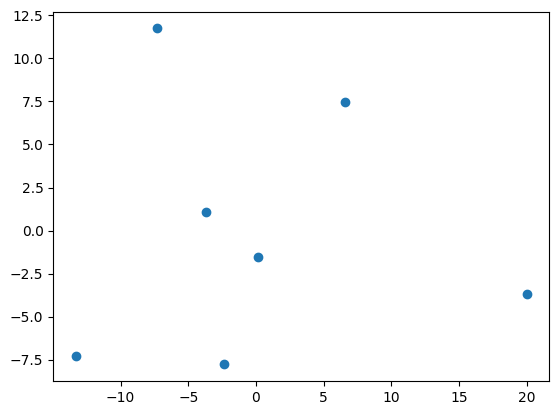

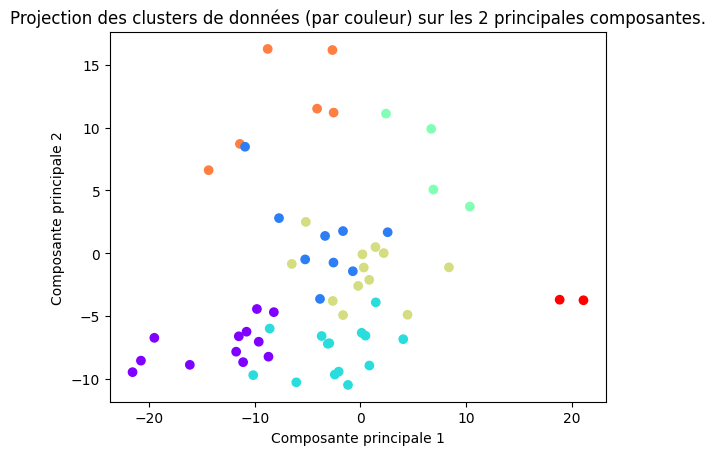

In [6]:
# Fit du modèle sur k=7
kmeans = KMeans(n_clusters=7, random_state=0)
cluster_labels = kmeans.fit_predict(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
data_clustering['cluster'] = cluster_labels

# PCA SUR LES BARYCENTRES DES CLUSTERS EN 2D
# Fitting de la PCA
cluster_centers = kmeans.cluster_centers_
n_components = 2
pca = PCA(n_components=n_components)
cluster_centers_pca = pca.fit_transform(cluster_centers)

# Projection de tous les points de données
new_points = pca.transform(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
data_clustering['projection_x'], data_clustering['projection_y'] = new_points[:,0], new_points[:, 1]
plt.scatter(cluster_centers_pca[:,0], cluster_centers_pca[:, 1])
plt.show()

# Plot the data and cluster centers
plt.scatter(data_clustering['projection_x'], data_clustering['projection_y'], c=data_clustering['cluster'], cmap='rainbow')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Projection des clusters de données (par couleur) sur les 2 principales composantes.')
plt.show()

# Amélioration de la RF par ajout des moyennes mobiles

  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp\ipykernel_22696\3658350243.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['moving_average'] = df.groupby('ligne')['retard_moyen_arrivee'].apply(lambda x: x.rolling(k).mean().shift())
  8%|▊         | 1/12 [00:00<00:08,  1.30it/s]C:\Users\User\AppData\Local\Temp\ipykernel_22696\3658350243.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt th

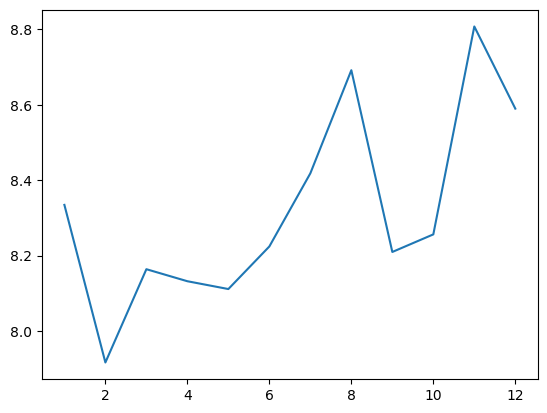

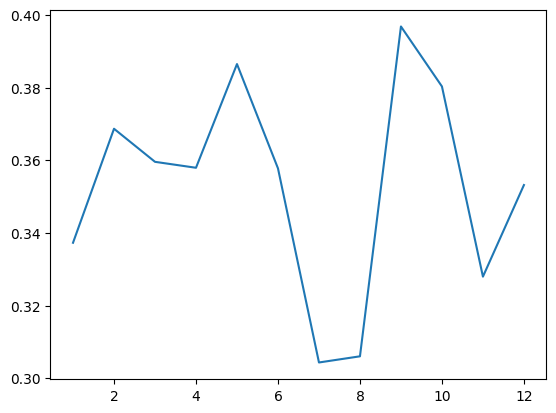

Le gain optimal est obtenu pour k=2 et permet un diminution de l'erreur de 5.01455557932356%.


In [120]:
data = load_data()

#PREPROCESSING
creer_feature_ligne(data)

data['mois'], data['annee'] = data['date'].apply(lambda date: date.split('-')[1]),  data['date'].apply(lambda date: date.split('-')[0])

def add_moving_average(data, k):
    if k>0:
        df = copy.deepcopy(data)
        df.sort_values(['ligne', 'annee', 'mois'], inplace=True)
        df['moving_average'] = df.groupby('ligne')['retard_moyen_arrivee'].apply(lambda x: x.rolling(k).mean().shift())
        df.sort_index(inplace=True)
        df = df[df['moving_average'].notna()]
        return df
    else:
        return data

# RECHERCHE DE LA FENETRE OPTIMALE
num_months = list()
maes = list()
r2s = list()

def test_moving_averages(data):
    for k in tqdm(range(1,13)):
        df = add_moving_average(data,k)
        X = df[['service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu', 'ligne', 'mois', 'moving_average']]
        y = df['retard_moyen_arrivee']
        # One-Hot Encoding pour les colonnes catégorielles
        X = pd.get_dummies(X, columns=['gare_depart', 'gare_arrivee', 'service', 'ligne'])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        rf = RandomForestRegressor(n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=None, bootstrap=True)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        num_months.append(k)
        maes.append(mae)
        r2s.append(r2)
    
    plt.plot(num_months, maes)
    plt.show()
    plt.plot(num_months, r2s)
    plt.show()
test_moving_averages(data)
print(f"Le gain optimal est obtenu pour k={1+np.argmin(np.array(maes))} et permet un diminution de l'erreur de {(-min(maes)+maes[0])/maes[0]*100}%.")